# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Select paths                 |                                               |
| 6. Run Fit                    |                                               |
| 7. Save project               ||
| 8. Verify fit results         ||
| 8.1 If not OK revise parameners and refit (go to 2.4)||
| 8.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


## Libraries
Libraries required for running fit on the XAS data.


In [1]:
# managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf

from larch import Interpreter
import larch_plugins as lp

# File handling
from pathlib import Path

#plotting library
%matplotlib inline
import matplotlib.pyplot as plt

# subprocess library used to run perl script
import subprocess

#library for writing to log
import logging

## Custom Functions

The following cell contains the defined functions (methods) for processing XAS files.

- **set_logger** intialises the logging.
- **get_files_list** returns a list of files in the directory matching the given file pattern.
- **calc_with_defaults ** recalculates mu, normal, pre-edge for each group being processed.
    


In [2]:
 #######################################################
# |                Initialise log file                | #
# V  provide the path and name of the log file to use V #
 #######################################################
    
def set_logger(log_file):
    logger = logging.getLogger()
    fhandler = logging.FileHandler(filename=log_file, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    # prevent matplotlib font manager from writing to log
    logging.getLogger('matplotlib.font_manager').disabled = True
    logger.setLevel(logging.DEBUG)

 #######################################################
# |                  Get a list of files              | #
# V       provide the path and pattern to match       V #
 #######################################################
    
#reading all files with the same extension files from a dir
def get_files_list(source_dir, f_pattern):
    i_counter = 0
    files_list = []
    for filepath in sorted(source_dir.glob(f_pattern)):
        i_counter += 1
        files_list.append(filepath)
    return files_list

 #######################################################
# |         Athena recalculates everything so we      | #
# |      need to create a function that calculates    | #
# V               all for each new group              V #
 #######################################################

def calc_with_defaults(xafs_group):
    # calculate mu and normalise with background extraction
    # should let the user specify the colums for i0, it, mu, iR. 
    if not hasattr(xafs_group, 'mu'):
        xafs_group = get_mu(xafs_group)
    # calculate pre-edge and post edge and add them to group
    # need to read parameters for pre-edge before background calculation with  
    # defaul values undo the work of previous step (setting pre-edge limits).
    pre_edge(xafs_group, pre1=xafs_group.bkg_params.pre1, pre2=xafs_group.bkg_params.pre2)
    #pre_edge(xafs_group)
    # perform background removal
    autobk(xafs_group) # using defaults so no additional parameters are passed
    # calculate fourier transform
    xftf(xafs_group)#, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
    return xafs_group


 #######################################################
# |       The code for plotting Nmu vs E repeats      | #
# |   so it is useful to have a plotting function     | #
# V            to reduce duplicated code              V #
 #######################################################
# plot flat normalised mu vs Energy for selected groups
def plot_Nxmu_E(athena_project, group_keys, group_names,
                            title = "Normalised $\mu$ vs E", xlimits = None,
                            ylimits = None):    
    # plot mu vs flat normalised mu for selected groups
    for group_key in group_keys:
        gr_0 = extract_athenagroup(athena_project._athena_groups[group_key])
        # recalculate normalisation
        calc_with_defaults(gr_0)
        plt.plot(gr_0.energy, gr_0.flat, label=group_names[group_key])

    # set plot format
    plt.xlabel("Energy")
    plt.ylabel("Normalised $\mu$" )
    plt.title(title)
    plt.grid(linestyle=':', linewidth=1) #show and format grid
    if xlimits != None:
        plt.xlim(xlimits[0],xlimits[1])
    if ylimits != None:
        plt.ylim(ylimits[0],ylimits[1])
    plt.legend()
    return plt, gr_0

 ########################################################
# |                Get scattering paths                | #
# | larch does not include a means for running atoms   | #
# | need to get input for feff and calculate paths     | #
# | currently the fastest option is to run Artemis to  | #
# | obtain the input (.inp) file for feff from a '.cif'| #
# V or '.inp' file                                     V #
 ########################################################
def run_feff(var = "FeS2.inp"):
    crystal_f = Path(var)
    feff_dir = crystal_f.name[:-4]+"_feff"
    feff_inp = crystal_f.name[:-4]+"_feff.inp"
    retcode = subprocess.call(["perl", "feff_inp.pl", var, feff_dir, feff_inp])
    if retcode == 0:
        print("Passed!")
    else:
        print("Failed!")

    # run feff and get the paths
    from larch.xafs.feffrunner import feff6l
    #feff6l(folder='.', feffinp='feff.inp', verbose=True)
    feff6l(folder = feff_dir, feffinp=feff_inp)
 ########################################################
# |                Read GDS parameters                 | #
# | read parameters from gds file                      | #
# | each line contains a parameter defined as          | #
# V type name = value                                  V #
 ########################################################
# guess amp = 1.00000
# guess enot = 0
# skip delr = 0
# guess ss = 0.00300
# guess alpha = 0
# guess ss2 = 0.00300
# guess ss3 = ss2
# guess ssFe = 0.00300
# skip ss4 = 0.00300
##############################
def read_gds(gds_file = "FeS2_dmtr.gds"):
    session = Interpreter()
    dgs_group = lp.fitting.param_group(_larch=session)
    with open('FeS2_dmtr.gds', 'r') as reader:
        # Read and print the entire file line by line
        gds_par = reader.readline()
        while gds_par != '':  # The EOF char is an empty string
            gds_par_def = gds_par.split()
            #gds file structure:
            # type name = value
            gds_type = gds_par_def[0]
            gds_name = gds_par_def[1]
            gds_val = 0.0
            gds_exp = ""
            #print(gds_par_def, "\n", end='')
            try:
                gds_val = float(gds_par_def[3])
            except ValueError:
                #print("Not a float value")
                gds_val = 0.00
                gds_exp = gds_par_def[3]
            one_par = None
            if gds_type == "guess":
                one_par = lp.fitting.guess(name=gds_name ,value=gds_val, vary=True, expr=gds_exp )
            elif gds_type == "def":
                one_par = lp.fitting.param(name=gds_name ,value=gds_val, vary=False, expr=gds_exp )
            if one_par != None:
                 dgs_group.__setattr__(gds_par_def[1],one_par )
            gds_par = reader.readline()
    return dgs_group
      
# show plot of normalised data
def plot_normalised(xafs_group):
        plt.plot(xafs_group.energy, xafs_group.mu, label=xafs_group.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        plt.title("pre-edge and post_edge fitting to $\mu$")
        plt.legend() # show legend
        return plt

## Input parameters (variables)

The variables in the next cell indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.


In [3]:
# variables that can be changed to process different datasets
data_path = ".\\rh4co\\"
file_pattern = "*.prj"
f_prefix = "rh4co"
crystal_file = "..\\cif_files\\C12O12Rh4.cif" #"FeS2.inp"
gds_parms_f = "rh4co.gds"
sel_paths_f = "rh4co.csv"
top_count = 4
show_graph = True # False to prevent showing graphs

## Main function
The code in the cell below performs the bulk of the processing for task 2 calling functions defined above and using the input parameters.

The three operations for generating paths, selecting paths and defining parameters are performed once before processing the input files in the list

### Generate paths 
Larch does larch does not include a means for running **Atoms**. Atoms is needed to get input for **FEFF** and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for FEFF from a crystal file ('.cif' or '.inp').

The run_feff function, defined above, uses the subprocess library to call perl to execute a script that runs Artemis Atoms, and saves the output file ('.inp') in a new directory. The file is then be used to run FEFF from Larch to calculate scattering paths.

### Select paths and set parameters
Select paths and set parameters are tasks which can be performed for the first fit  and then reused for all following datasets.  

#### Set Parameters

The read_gds function, defined above, creates the parameters group (GDS in Artemis) from a gds file. The code uses lp.fitting.param_group and lp.fitting.param instead of importing Group and Parameter (does not work with Jupyter). The parameter values are read from a text file.

#### Select Paths
The selection of scattering paths is handled by the read_paths function. Each scattering path is loaded while setting the amplitude, $\Delta E_0$, $\Delta R$ and $\sigma^2$ parameters using the GDS parameters defined previously. The groups are then added returned as a list of paths to be used for the fits.


[root] INFO : Started processing
[root] INFO : Input variables:
[root] INFO : 	data_path    = .\rh4co\
[root] INFO : 	file_pattern = *.prj
[root] INFO : 	f_prefix     = rh4co
[root] INFO : 	crystal_file = ..\cif_files\C12O12Rh4.cif
[root] INFO : 	top_count    = 4


rh4co_fit\process.log


[root] INFO : GDS Parameters read OK


Passed!
 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : Rh4 (C O)12
 : Wei, C.H.
 : Structural analyses of tetracobalt dodecacarbonyl and tetrarhodium
 : dodecacarbonyl. crystallographic treatments of a disordered structure and
 : a twinned composite
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : free atom potential and density for atom type    3
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : overlapped potential and density for unique potential    3
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts fo

[root] INFO : Completed FEFF


 : Feff done.  Have a nice day.


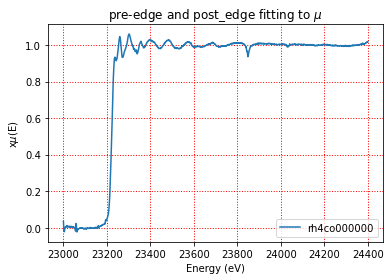

[root] INFO : Processed file: 1 rh4co000000


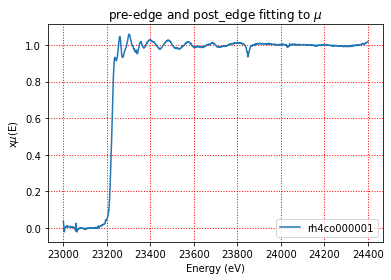

[root] INFO : Processed file: 2 rh4co000001


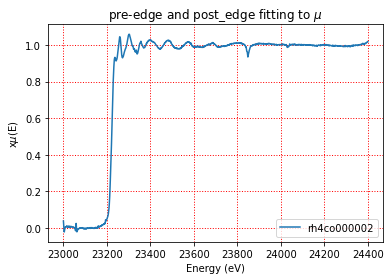

[root] INFO : Processed file: 3 rh4co000002


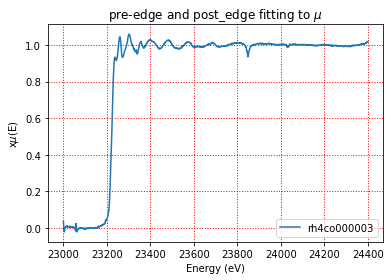

[root] INFO : Processed file: 4 rh4co000003
[root] INFO : Finished processing


In [4]:
# create the path for storing results
base_path = Path("./" , f_prefix+"_fit")
Path(base_path).mkdir(parents=True, exist_ok=True)

log_file = Path("./",base_path,"process.log")
print(log_file)
# set path for log
set_logger(log_file)

# get the list of files to process
source_path = Path(data_path)
files_list = get_files_list(source_path, file_pattern)
xas_data = {}

logging.info("Started processing")
logging.info("Input variables:")
logging.info("\tdata_path    = " + data_path)
logging.info("\tfile_pattern = " + file_pattern)
logging.info("\tf_prefix     = " + f_prefix)
logging.info("\tcrystal_file = " + crystal_file)
logging.info("\ttop_count    = " + str(top_count))

# read the gds parameters from input file
gds = read_gds(gds_parms_f)
logging.info("GDS Parameters read OK")

# run feff on crystal file to generate scattering paths
run_feff(crystal_file)
logging.info("Completed FEFF")
# read the selected paths list to access relevant paths 
# generated from FEFF
#selected_paths = read_paths(sel_paths_f)

# counter for break
i_count = 0
for a_file in files_list:
    project_name = a_file.name
    data_prj = read_athena(a_file)
    group_keys = list(data_prj._athena_groups.keys())

    #group_names = {}

    #for group_key in group_keys:
    #    group_names[group_key] = group_key

    data_group = extract_athenagroup(data_prj._athena_groups[group_keys[0]])
    if show_graph:    
        # plot normalised mu on energy
        # plot mu vs flat normalised mu for selected groups
        #plt, data_group = plot_Nxmu_E(data_prj, group_keys, group_names)
        plt = plot_normalised(data_group)
        plt.show()
    
        
    i_count +=1
    
    logging.info("Processed file: "+ str(i_count) +" " + group_keys[0])
    
    if i_count == top_count:
        break
       
logging.info("Finished processing")

In [5]:
var ="..\\cif_files\\C12O12Rh4.cif"; "FeS2.inp"
crystal_f = Path(var)
print(crystal_f.name)
print(crystal_f.parent)
prefix = "fes2"
feff_dir = var[:-4]+"_feff"
feff_dir 
run_feff(var)

C12O12Rh4.cif
..\cif_files
Passed!
 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : Rh4 (C O)12
 : Wei, C.H.
 : Structural analyses of tetracobalt dodecacarbonyl and tetrarhodium
 : dodecacarbonyl. crystallographic treatments of a disordered structure and
 : a twinned composite
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : free atom potential and density for atom type    3
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : overlapped potential and density for unique potential    3
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potent

## Select paths from FEFF
To select a path change the value of the select column to 1 in the table displayed after running the cell below.

In [7]:
import re

import ipysheet

def show_paths(var = "FeS2.inp"):
    crystal_f = Path(var)
    feff_dir = crystal_f.name[:-4]+"_feff"
    feff_inp = crystal_f.name[:-4]+"_feff.inp"
    feff_files = "files.dat"
    input_file = Path(feff_dir, feff_files)
    #check if feff dir exists
    if input_file.parent.exists() and input_file.exists():
        logging.info(str(input_file.parent) + " path and "+ str(input_file)+ " found")
    else:
        logging.info(str(input_file.parent) + " path not found, run feff before running select paths")
        return False
    count = 0
    # the .dat data is stored in fixed width strings 
    field_widths = [[0,13],[14,21],[22,31],[32,41],[42,48],[49,61]]
    is_meta = True
    data_headers = []
    path_count = 0
    paths_data = []
    logging.info("Reading from: "+ str(input_file))
    with open(input_file) as datfile:
        dat_lines = datfile.readlines()
        for a_line in dat_lines:
            count += 1
            if re.match('-*', a_line.strip()).group(0)!= '':
                is_meta = False
                logging.info("{}: {}".format(count, a_line.strip()))
            elif is_meta:
                logging.info("{}: {}".format(count, a_line.strip()))
            elif data_headers == []:
                data_headers = [a_line[s:e].strip().replace(' ','_') for s,e in field_widths]
                logging.info("headers:"+ str(data_headers))
                data_headers.append('select')
                paths_data.append(data_headers)
            else:
                path_count += 1
                data_values = [a_line[s:e].strip() for s,e in field_widths]
                data_values.append(0)
                data_values[0] = feff_dir+"/"+data_values[0]
                paths_data.append(data_values)
    # use data to populate spreadsheet
    
    pathsheet = ipysheet.sheet(rows=path_count+1, columns=7)
    ipysheet.cell_range(paths_data)
    return pathsheet

path_sheet = select_paths('FeS2.inp')
display(path_sheet)


[root] INFO : FeS2_feff path and FeS2_feff\files.dat found
[root] INFO : Reading from: FeS2_feff\files.dat
[root] INFO : 1: name:     Iron sulfide (pyrite)                        Feff 6L.02  potph 4.12
[root] INFO : 2: formula:  FeS_2
[root] INFO : 3: refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
[root] INFO : 4: Abs   Z=26 Rmt= 1.116 Rnm= 1.361 K shell
[root] INFO : 5: Pot 1 Z=26 Rmt= 1.121 Rnm= 1.372
[root] INFO : 6: Pot 2 Z=16 Rmt= 1.120 Rnm= 1.390
[root] INFO : 7: Gam_ch=1.325E+00 H-L exch
[root] INFO : 8: Mu=-4.281E+00 kf=2.108E+00 Vint=-2.122E+01 Rs_int= 1.720
[root] INFO : 9: -------------------------------------------------------------------------------
[root] INFO : headers:['file', 'sig2', 'amp_rati', 'deg', 'nlegs', 'r_effective']


Sheet(cells=(Cell(column_end=6, column_start=0, row_end=48, row_start=0, squeeze_column=False, squeeze_row=Fal…

## Define parameters for each selected path
To define the parameters enter the corresponding values in the table that appears after running the code in the cell below this message

In [8]:
df_sheet = ipysheet.to_dataframe(path_sheet)
files = []
for f_name, selected in zip(df_sheet["A"], df_sheet["G"]):
    if selected == '1':
        files.append(f_name)    
        
sheet = ipysheet.sheet(rows=5, columns=4)
row = ipysheet.row(0, [0, 1, 2, 3], background_color="red")
column = ipysheet.column(1, ["a", "b", "c", "d"], row_start=1, background_color="green")
cells = ipysheet.cell_range([["hi", "ola"], ["ciao", "bonjour"], ["hallo", "guten tag"]],
                            row_start=1, column_start=2, background_color="yellow")
sel_paths_data = [[0 for col in range(6)] for row in range(4)]
sel_paths_data[:0]=[['file','label','s02','e0','sigma2','deltar']]
ps_row = 1
for a_name in files:
    sel_paths_data[ps_row][0] = a_name
    ps_row += 1

sp_sheet = ipysheet.sheet(rows=len(files)+1, columns=6)
ipysheet.cell_range(sel_paths_data)
display(sp_sheet)

Sheet(cells=(Cell(column_end=5, column_start=0, row_end=4, row_start=0, squeeze_column=False, squeeze_row=Fals…

In [9]:
sp_data = ipysheet.to_dataframe(sp_sheet)
sp_data
sp_data
# use data frame to create selected paths list

,A,B,C,D,E,F
0,file,label,s02,e0,sigma2,deltar
1,FeS2_feff/feff0001.dat,0,0,0,0,0
2,FeS2_feff/feff0002.dat,0,0,0,0,0
3,FeS2_feff/feff0003.dat,0,0,0,0,0
4,FeS2_feff/feff0004.dat,0,0,0,0,0


## Select Paths
The selection of scattering paths is shown in the following code. Each scattering path is loaded while setting the amplitude, $\Delta E_0$, $\Delta R$ and $\sigma^2$ parameters using the GDS parameters defined previously.

The groups are then added to a list of paths to be used for the fit.
This task is different from the one in Demeter

In [ ]:
# import library for managing csv files
import csv

# getting the data from the demeter csv_file, 
# with no headers does not work. We need an
# alternative for using the FEFF data produced
# by Larch

def get_csv_no_id_no_head(input_file):
    csv_data = {}
    with open(input_file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        row_id = 0
        for row in reader:
            csv_data[row_id]=row
            row_id += 1
    return csv_data

# select paths
# labelling for reference only using Artemis-FEFF given names
def read_paths (sel_paths = 'FeS2_dmtr.csv', crystal_file = 'FeS2.inp'):
    session = Interpreter()
    csv_paths = get_csv_no_id_no_head(sel_paths)
    print(csv_paths)
    p_s1 = lp.xafs.FeffPathGroup(filename = 'fes2_feff/feff0001.dat',
                                  label    = "S1",
                                  s02      = 'amp',
                                  e0       = 'enot',
                                  sigma2   = 'ss',
                                  deltar   = 'alpha*reff',
                                  _larch   = session)
    p_s2 = lp.xafs.FeffPathGroup(filename = 'fes2_feff/feff0002.dat',
                                  label    = "S2",
                                  s02      = 'amp',
                                  e0       = 'enot',
                                  sigma2   = 'ss2',
                                  deltar   = 'alpha*reff',
                                  _larch   = session)
    p_s3 = lp.xafs.FeffPathGroup(filename = 'fes2_feff/feff0003.dat',
                                  label    = "S3",
                                  s02      = 'amp',
                                  e0       = 'enot',
                                  sigma2   = 'ss3',
                                  deltar   = 'alpha*reff',
                                  _larch   = session)
    p_fe = lp.xafs.FeffPathGroup(filename = 'fes2_feff/feff0004.dat',
                                  label    = "Fe",
                                  s02      = 'amp',
                                  e0       = 'enot',
                                  sigma2   = 'ssfe',
                                  deltar   = 'alpha*reff',
                                  _larch   = session)
    # return path list
    return [p_s1, p_s2, p_s3, p_fe]

selected_paths = read_paths()#sel_paths_f, crystal_file)
selected_paths


In [ ]:
sel_paths = 'FeS2_dmtr.csv'
csv_paths = get_csv_no_id_no_head(sel_paths)

print(csv_paths)

from IPython.display import HTML, display
import tabulate
data = [[1,2,3],
        [4,5,6],
        [7,8,9],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

table = [["Sun",696000,1989100000],
         ["Earth",6371,5973.6],
         ["Moon",1737,73.5],
         ["Mars",3390,641.85]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

## Run Fit

XAS fitting is performed in three steps:
1. Create a Transform group to holds the set of Fourier transform parameters, fitting ranges, and space in which the data and sum of paths are to be compared (R space)
2. Create a Dataset group,consistaining of the three components required for fitting(data, paths, and transform group)
3. FEFFIT is run with the list of parameters (gds) for the fit, and the dataset or list of datasets groups.


In [ ]:
# run fit
# create the transform grup (prepare the fit space).
trans = lp.xafs.TransformGroup(fitspace='r', kmin=3, kmax=14, kw=2, dk=1, window='hanning', rmin=1.4,
                               rmax=3.0, _larch=session)


dset = lp.xafs.FeffitDataSet(data=data_group, pathlist=selected_paths, transform=trans, _larch=session)

out = lp.xafs.feffit(gds, dset, _larch=session)

## Review fit results
The results of the fit are stored in the dataset. These can be plotted and printed as follows.

In [ ]:
fig = plt.figure()
plt.plot(dset.data.r, dset.data.chir_mag, color='b')
plt.plot(dset.data.r, dset.data.chir_re, color='b', label='expt.')
plt.plot(dset.model.r, dset.model.chir_mag, color='r')
plt.plot(dset.model.r, dset.model.chir_re, color='r', label='fit')
plt.ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.xlabel("Radial distance/$\mathrm{\AA}$")
plt.xlim(0, 5)

plt.fill([1.4, 1.4, 3.0, 3.0],[-3, 3, 3, -3], color='g',alpha=0.1)
plt.text(2.35, -2.5, 'fit range')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# Creating the chifit plot from scratch
#from larch.wxlib.xafsplots import plot_chifit
#plot_chifit(dset, _larch=session)
ax1.plot(dset.data.k, dset.data.chi*dset.data.k**2, color='b', label='expt.')
ax1.plot(dset.model.k, dset.model.chi*dset.data.k**2 , color='r', label='fit')
ax1.set_xlim(0, 15)
ax1.set_xlabel("$k (\mathrm{\AA})^{-1}$")
ax1.set_ylabel("$k^2$ $\chi (k)(\mathrm{\AA})^{-2}$")
ax1.fill([3.0, 3.0, 14.0, 14.0],[-3, 3, 3, -3], color='g',alpha=0.1)
ax1.text(12.35, -2.5, 'fit range')
ax1.legend()

ax2.plot(dset.data.r, dset.data.chir_mag, color='b', label='expt.')
ax2.plot(dset.model.r, dset.model.chir_mag, color='r', label='fit')
ax2.set_xlim(0, 5)
ax2.set_xlabel("$R(\mathrm{\AA})$")
ax2.set_ylabel("$|\chi(R)|(\mathrm{\AA}^{-3})$")
ax2.legend(loc='upper right')
ax2.fill([1.4, 1.4, 3.0, 3.0],[0, 3, 3, 0], color='g',alpha=0.1)
ax2.text(2.35, 2.75, 'fit range')
plt.show()
 

In [ ]:
print(lp.xafs.feffit_report(out, _larch=session))

In [ ]:
vars(gds)

In [ ]:
vars(p_s1)

#### Things to do
- for manual task
 - Allow setting parameters interactively (not from CSV)
 - Move all functions to libraries (hide complexity from researchers)
 - Test running with textbook example (FeS2)
 - Test running with sample data (Rh4CO12)
- 
 - replicate in batch processing (reading of parameters and paths)